<h1>光頭傑夫製作</h1><img src="https://rolqiw.bl.files.1drv.com/y4mYqkObWmQmdJFd8pab8t8m7d_mFhh3_YG63fiAnPaG6gjahHFt0n087pF97x1W2wemm7hd4ZdiPD2OxoPtqcCD_4-Jy-fojnt97kGGWR4Hnq0-9Ny61afd7WVHVTmF_9pcr45OFDFSwLKByeQU1q9TjwKk-HsNmWVsW1eGQ4Gi-9G4pQ5DYoTxswYJ5r5dLF-kKsA1InEyrqmV3kF5pm4WQ?width=658&height=584&cropmode=none" width=160px align="left" />

### <span style="color:red ">以下是我們需要的量化分析套件:
---    
    1. Jupyter Notebook環境中，第一次安裝過就好，以後直接導入模組就好。
    2. 如果你是在Colab的環境中運作檔案，請每次安裝

! pip install backtrader

### <span style="color:red ">以下是我們後續輸出分析結果需要的方程式:
---    
    1. 每次你要輸出策略的績效結果時，下面這格你都要跑

In [1]:
def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in a nice format.
    '''
    #Get the results we are interested in
    total_closed = ''
    total_won =''
    total_lost =''
    win_streak = ''
    lose_streak = ''
    pnl_net =''
    strike_rate =''
    
    if len(analyzer.total)>2:
        total_closed = analyzer.total.closed
        total_won = analyzer.won.total
        total_lost = analyzer.lost.total
        win_streak = analyzer.streak.won.longest
        lose_streak = analyzer.streak.lost.longest
        pnl_net = round(analyzer.pnl.net.total,2)
    
    if total_closed:
        strike_rate=round((total_won / total_closed) * 100,2)
    else:
        strike_rate='沒有完整交易'
    print("策略運作分析結果:")
    print(f'獲利累積次數 : {str(total_won)}')
    print(f'損失累積次數 : {str(total_lost)}')
    print(f'獲利損失次數比 : {str(strike_rate)}')
    print(f'最高連續獲利交易次數 : {str(win_streak)}')
    print(f'最高連續損失交易次數 : {str(lose_streak)}')
    print(f'淨利結算 : {str(pnl_net)}')
    

## <span style="color:red ">  <策略1-with Commision>用DMI做個回測策略吧!

### <span style="color:red "><策略1.1- with Commision>導入需求模組

In [2]:
from datetime import datetime
import pandas as pd
import yfinance as yf
import backtrader as bt

### <span style="color:red "><策略1.2- with Commision>建立交易策略

In [12]:
class DMIStrategy(bt.Strategy):
   
    # Standard DMI Parameters
    params = dict(
          ma_period=17, 
          adxLimited=27
    )

    def __init__(self):
        self.DMI = bt.indicators.DMI(period=self.p.ma_period)
                                       
        self.order = None
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return
        
        # check if there is already a position
        if not self.position:
            if self.DMI.adx[0] > self.p.adxLimited and self.DMI.plusDI[0]>self.DMI.minusDI[0]: 
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy(size=1000)

        else:
            # sell condition
            if self.DMI.adx[0] > self.p.adxLimited and self.DMI.plusDI[0]<self.DMI.minusDI[0]:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell(size=1000)

### <span style="color:red "><策略1.3- with Commision>抓取目標股票的歷史資料

In [4]:
data= yf.download(  '2330.tw',              #股票代碼
                    start='2022-3-30',      #資料開始日期
                    end='2023-3-30',         #資料結束日期
                    progress=False
                 )
data=bt.feeds.PandasData(dataname=pd.DataFrame({'open': data['Open'], 
                   'high': data['High'],
                   'low': data['Low'],
                   'close': data['Close'],
                   'volume': data['Volume'],
                  }))

### <span style="color:red "><策略1.4- with Commision>建立台股交易費用計算模式

In [13]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)


### <span style="color:red "><策略1.5- with Commision>建立回測分析「大腦」

In [14]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()

# set up the backtest
cerebro.adddata(data)
cerebro.broker.setcash(cash)
cerebro.addstrategy(DMIStrategy)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)

cerebro.broker.addcommissioninfo(comminfo)


### <span style="color:red "><策略1.6- with Commision>讓Analyzers來幫我診斷策略細節...-開始回測

In [15]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")

strategies = cerebro.run()
firstStrat = strategies[0]

# print the analyzers
printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())
print(f'持有資產總值: {cerebro.broker.getvalue():.2f}')

2022-05-31, 開出買單 --- 當時市場價格: 560.00
2022-06-01, 買單執行 --- 買價: 550.00, 成本: 550000.00, 手續費: 156.75
2022-06-02, 開出賣單 --- 當時市場價格: 540.00
2022-06-06, 賣單執行 --- 賣價: 541.00, 成本: 550000.00, 手續費: 1777.18
2022-06-06, 運作結果 --- 獲利狀況: -9000.00, 淨獲利: -10933.93
2022-07-18, 開出買單 --- 當時市場價格: 495.50
2022-07-19, 買單執行 --- 買價: 487.50, 成本: 487500.00, 手續費: 138.94
2022-07-19, 開出賣單 --- 當時市場價格: 491.00
2022-07-20, 賣單執行 --- 賣價: 502.00, 成本: 487500.00, 手續費: 1649.07
2022-07-20, 運作結果 --- 獲利狀況: 14500.00, 淨獲利: 12711.99
2022-11-09, 開出買單 --- 當時市場價格: 417.00
2022-11-10, 買單執行 --- 買價: 409.00, 成本: 409000.00, 手續費: 116.57
策略運作分析結果:
獲利累積次數 : 1
損失累積次數 : 1
獲利損失次數比 : 50.0
最高連續獲利交易次數 : 1
最高連續損失交易次數 : 1
淨利結算 : 1778.06
持有資產總值: 1122661.49


### <span style="color:red "><策略1.7- with Commision>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


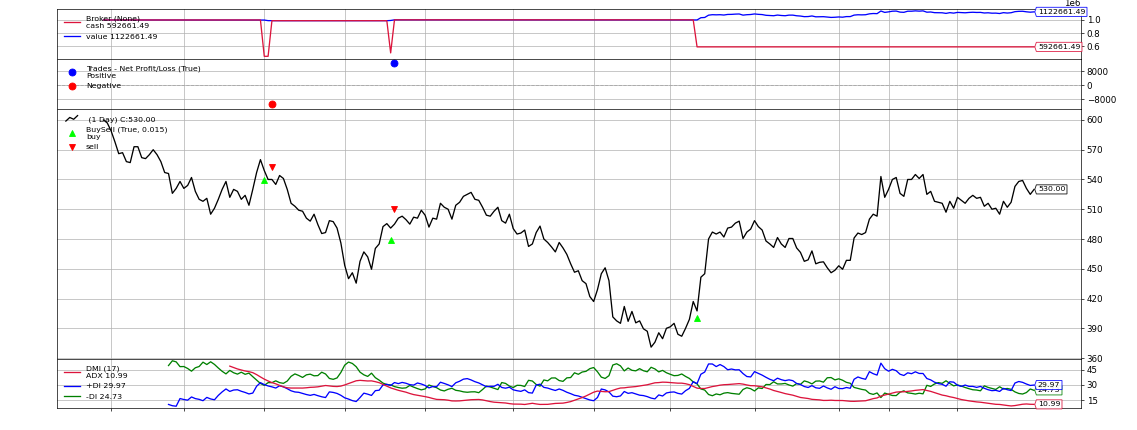

[[<Figure size 320x240 with 4 Axes>]]

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi']=50
# plot results
cerebro.plot(iplot=True, volume=False)

### <span style="color:red "><策略2- with Commision>我們想要來個參數特調DMI看看效果怎麼樣?
--------

### <span style="color:red "><策略2.2- with Commision>建立交易策略

In [9]:
class DMIStrategy(bt.Strategy):
   
    # Standard DMI Parameters
    params = dict(
          ma_period=14, 
          adxLimited=25
    )

    def __init__(self):
        self.DMI = bt.indicators.DMI(period=self.p.ma_period)
                                       
        self.order = None
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.price = order.executed.price
                self.comm = order.executed.comm
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return


    def next(self):
        # do nothing if an order is pending
        if self.order:
            return
        
        # check if there is already a position
        if not self.position:
            if self.DMI.adx[0] > self.p.adxLimited and self.DMI.plusDI[0]>self.DMI.minusDI[0]: 
                self.order = self.buy(size=1000)

        else:
            # sell condition
            if self.DMI.adx[0] > self.p.adxLimited and self.DMI.plusDI[0]<self.DMI.minusDI[0]:
                self.order = self.sell(size=1000)
    def stop(self):
        self.log(f'(DMI週期設定 = 週期:{self.p.ma_period:2d} ADX門檻設定 = {self.p.adxLimited:2d}) --- 淨利數值: {self.broker.getvalue()-cash:.2f}')
        self.params.totalValue=self.broker.getvalue()

### <span style="color:red "><策略2.4- with Commision>建立台股交易費用計算模式

In [10]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略2.5- with Commision>建立回測分析「大腦」,讓Analyzers來幫我診斷策略細節...-開始回測

In [11]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()
cerebro.optstrategy(DMIStrategy,ma_period=range(5,26),adxLimited=[13,15,18,20,22,25,27,28,30,32,35])
cerebro.adddata(data)
cerebro.broker.setcash(cash)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)


cerebro.broker.addcommissioninfo(comminfo)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name="ta")

opt_runs = cerebro.run(maxcpus=1)


for run in opt_runs:
    for strategy in run:
        print(f'參數組合:  週期={strategy.params.ma_period:2d}天,ADX門檻={strategy.params.adxLimited:2d}')
        try:
            printTradeAnalysis(strategy.analyzers.ta.get_analysis())
        except KeyError :
            print('沒有交易發生')
        print(f'持有資產總值: {strategy.params.totalValue:.2f}')
        print('--------------------------------------------------------')

2023-03-29, (DMI週期設定 = 週期: 5 ADX門檻設定 = 13) --- 淨利數值: -30288.03
2023-03-29, (DMI週期設定 = 週期: 5 ADX門檻設定 = 15) --- 淨利數值: -30288.03
2023-03-29, (DMI週期設定 = 週期: 5 ADX門檻設定 = 18) --- 淨利數值: -28622.62
2023-03-29, (DMI週期設定 = 週期: 5 ADX門檻設定 = 20) --- 淨利數值: -37593.06
2023-03-29, (DMI週期設定 = 週期: 5 ADX門檻設定 = 22) --- 淨利數值: -13370.84
2023-03-29, (DMI週期設定 = 週期: 5 ADX門檻設定 = 25) --- 淨利數值: -12925.48
2023-03-29, (DMI週期設定 = 週期: 5 ADX門檻設定 = 27) --- 淨利數值: -4661.83
2023-03-29, (DMI週期設定 = 週期: 5 ADX門檻設定 = 28) --- 淨利數值: -5662.11
2023-03-29, (DMI週期設定 = 週期: 5 ADX門檻設定 = 30) --- 淨利數值: 3210.56
2023-03-29, (DMI週期設定 = 週期: 5 ADX門檻設定 = 32) --- 淨利數值: -75151.10
2023-03-29, (DMI週期設定 = 週期: 5 ADX門檻設定 = 35) --- 淨利數值: -41772.05
2023-03-29, (DMI週期設定 = 週期: 6 ADX門檻設定 = 13) --- 淨利數值: -6957.83
2023-03-29, (DMI週期設定 = 週期: 6 ADX門檻設定 = 15) --- 淨利數值: -6957.83
2023-03-29, (DMI週期設定 = 週期: 6 ADX門檻設定 = 18) --- 淨利數值: 6754.25
2023-03-29, (DMI週期設定 = 週期: 6 ADX門檻設定 = 20) --- 淨利數值: -4248.89
2023-03-29, (DMI週期設定 = 週期: 6 ADX門檻設定 = 22) --- 淨利數值: -4634.99
20

2023-03-29, (DMI週期設定 = 週期:17 ADX門檻設定 = 13) --- 淨利數值: 12137.19
2023-03-29, (DMI週期設定 = 週期:17 ADX門檻設定 = 15) --- 淨利數值: -1082.08
2023-03-29, (DMI週期設定 = 週期:17 ADX門檻設定 = 18) --- 淨利數值: 38784.53
2023-03-29, (DMI週期設定 = 週期:17 ADX門檻設定 = 20) --- 淨利數值: 26953.59
2023-03-29, (DMI週期設定 = 週期:17 ADX門檻設定 = 22) --- 淨利數值: 54609.23
2023-03-29, (DMI週期設定 = 週期:17 ADX門檻設定 = 25) --- 淨利數值: 25704.49
2023-03-29, (DMI週期設定 = 週期:17 ADX門檻設定 = 27) --- 淨利數值: 122661.49
2023-03-29, (DMI週期設定 = 週期:17 ADX門檻設定 = 28) --- 淨利數值: 24983.42
2023-03-29, (DMI週期設定 = 週期:17 ADX門檻設定 = 30) --- 淨利數值: 42930.41
2023-03-29, (DMI週期設定 = 週期:17 ADX門檻設定 = 32) --- 淨利數值: -10933.94
2023-03-29, (DMI週期設定 = 週期:17 ADX門檻設定 = 35) --- 淨利數值: -20156.75
2023-03-29, (DMI週期設定 = 週期:18 ADX門檻設定 = 13) --- 淨利數值: -32783.01
2023-03-29, (DMI週期設定 = 週期:18 ADX門檻設定 = 15) --- 淨利數值: -44001.72
2023-03-29, (DMI週期設定 = 週期:18 ADX門檻設定 = 18) --- 淨利數值: -9855.87
2023-03-29, (DMI週期設定 = 週期:18 ADX門檻設定 = 20) --- 淨利數值: -4872.29
2023-03-29, (DMI週期設定 = 週期:18 ADX門檻設定 = 22) --- 淨利數值: 26770.21
202

最高連續獲利交易次數 : 2
最高連續損失交易次數 : 3
淨利結算 : -67970.72
持有資產總值: 932029.28
--------------------------------------------------------
參數組合:  週期= 7天,ADX門檻=13
策略運作分析結果:
獲利累積次數 : 4
損失累積次數 : 7
獲利損失次數比 : 36.36
最高連續獲利交易次數 : 2
最高連續損失交易次數 : 3
淨利結算 : 62086.7
持有資產總值: 1063936.22
--------------------------------------------------------
參數組合:  週期= 7天,ADX門檻=15
策略運作分析結果:
獲利累積次數 : 4
損失累積次數 : 7
獲利損失次數比 : 36.36
最高連續獲利交易次數 : 2
最高連續損失交易次數 : 3
淨利結算 : 62086.7
持有資產總值: 1063936.22
--------------------------------------------------------
參數組合:  週期= 7天,ADX門檻=18
策略運作分析結果:
獲利累積次數 : 4
損失累積次數 : 5
獲利損失次數比 : 44.44
最高連續獲利交易次數 : 2
最高連續損失交易次數 : 3
淨利結算 : 64795.65
持有資產總值: 1066645.17
--------------------------------------------------------
參數組合:  週期= 7天,ADX門檻=20
策略運作分析結果:
獲利累積次數 : 4
損失累積次數 : 4
獲利損失次數比 : 50.0
最高連續獲利交易次數 : 2
最高連續損失交易次數 : 2
淨利結算 : 97614.48
持有資產總值: 1091461.71
--------------------------------------------------------
參數組合:  週期= 7天,ADX門檻=22
策略運作分析結果:
獲利累積次數 : 4
損失累積次數 : 3
獲利損失次數比 : 57.14
最高連續獲利交易次數 : 2
最高連續損失交易次數 : 2
淨利結算 : 5